In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33677")
client

<Client: 'tcp://127.0.0.1:33677' processes=8 threads=64, memory=895.63 GiB>

In [18]:
client.restart()

<Client: 'tcp://127.0.0.1:33677' processes=0 threads=0, memory=0 B>

In [3]:
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
import os.path as op
import numpy as np
import xgcm 
%matplotlib inline

In [4]:
savedir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/TWA/'

$$ {\bf U}^{qs} = \sum_{\rho'\leq \rho} \hat{\bf u} \Delta \overline{z}^\rho - \overline{\sum_{-H\leq z\leq \overline{z}^\rho} {\bf u} \Delta z} $$

$$ {\bf \Psi}^{qs} = {\bf U}^{qs} \times \hat{\bf z} = \left(\begin{array}{c}V^{qs}\\ -U^{qs}\\ 0 \end{array}\right)$$

$$ {\bf A} = \left(\begin{array}{ccc} 
0 & 0 & -\Psi^{qs}_2\\
0 & 0 & \Psi^{qs}_1\\
\Psi^{qs}_2 & -\Psi^{qs}_1 & 0
\end{array}\right) $$

In [5]:
zeta_bar = xr.open_zarr('zeta_temp.zarr').zeta_bar
sigma_bar = xr.open_zarr('sigma_bar_temp.zarr').sigma_bar
ds_hat = xr.open_dataset('ds_hat.zarr')
ds_hat

/home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:    (YC: 400, XC: 400, T: 51)
Coordinates:
  * T          (T) float64 0.0 0.16 0.32 0.48 0.64 ... 7.36 7.52 7.68 7.84 8.0
  * XC         (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * YC         (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
Data variables: (12/22)
    PTRACER01  (YC, XC, T) float32 ...
    PTRACER02  (YC, XC, T) float32 ...
    PTRACER03  (YC, XC, T) float32 ...
    PTRACER04  (YC, XC, T) float32 ...
    PTRACER05  (YC, XC, T) float32 ...
    PTRACER06  (YC, XC, T) float32 ...
    ...         ...
    PTRACER17  (YC, XC, T) float32 ...
    PTRACER18  (YC, XC, T) float32 ...
    PTRACER19  (YC, XC, T) float32 ...
    PTRACER20  (YC, XC, T) float32 ...
    U          (YC, XC, T) float32 ...
    V          (YC, XC, T) float32 ...

In [6]:
Tcenter = np.linspace(0,8, 51)
dT = Tcenter[1] - Tcenter[0]
Touter = np.append(Tcenter - dT/2, Tcenter[-1] + dT/2)
ds_hat = ds_hat.assign_coords({'Tc':Touter})

grid_iso = xgcm.Grid(ds_hat, coords={'T':{'center':'T', 'outer':'Tc'}},
                     periodic='X')

In [7]:
dzetab = grid_iso.interp(grid_iso.diff(zeta_bar, 'T', boundary='extend')/ dT, 
                         'T', boundary='extend'
                        )

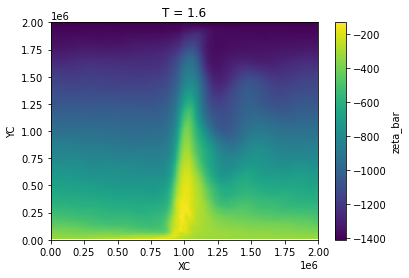

In [7]:
zeta_bar.isel(T=10).plot()

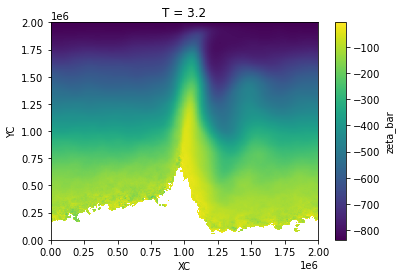

In [30]:
zeta_bar.isel(T=20).plot()

In [56]:
Vqs1 = grid_iso.interp(grid_iso.cumsum(ds_hat.V * dzetab,
                                       'T',boundary='extend'),
                       'T',boundary='extend'
                      ).where(zeta_bar<0.).compute()
Vqs1

<xarray.DataArray 'mul-fe0ebfa91c739fff77da277cbad0db02' (YC: 400, XC: 400,
                                                          T: 51)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,  0.00000000e+00, -7.45015964e-02, ...,
                     nan,             nan,             nan],
        [            nan,  0.00000000e+00, -6.02814518e-02, ...,
                     nan,             nan,             nan],
        [            nan,  0.00000000e+00, -3.10518667e-02, ...,
                     nan,             nan,             nan],
...
         -2.44934235e+01, -2.46281147e+01,             nan],
        [-8.59257221e-01, -1.61493254e+00, -3.43417072e+00, ...,
         -2.38395367e+01, -2.39724922e+01,             nan],
        [-9.50814664e-01, -1.75959301e+00, -3.67944479e+00, ...,
         -2.34712086e+01, -2.35946560e+01,             nan]],

       [[-7.41587818e-01, -1.24366295e+00, -2.57527876e+00, ...,
         -1.58656101e+01, -1.59273701e+01,             nan],
        [-7.67185271e-01, -1.23667884e+00, -2.44815350e+00, ...,
         -1.49188557e+01, -1.49830875e+01,             nan],
        [-7.02098012e-01, -1.06191826e+00, -2.05114579e+00, ...,
         -1.36975994e+01, -1.37605238e+01,             nan],
        ...,
        [-7.37966239e-01, -1.15479910e+00, -2.38285398e+00, ...,
         -1.72088165e+01, -1.72790909e+01,             nan],
        [-7.15851068e-01, -1.10751569e+00, -2.26397085e+00, ...,
         -1.65694618e+01, -1.66361275e+01,             nan],
        [-7.21314728e-01, -1.18158531e+00, -2.45040035e+00, ...,
         -1.63475075e+01, -1.64119587e+01,             nan]]],
      dtype=float32)
Coordinates:
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * T        (T) float64 0.0 0.16 0.32 0.48 0.64 0.8 ... 7.36 7.52 7.68 7.84 8.0

In [72]:
Uqs1 = grid_iso.interp(grid_iso.cumsum(ds_hat.U * dzetab,
                                       'T',boundary='extend'),
                       'T',boundary='extend'
                      ).where(zeta_bar<0.).compute()
Uqs1

<xarray.DataArray 'mul-57b6679c7c55d1d0f6c7bd4e59ce334e' (YC: 400, XC: 400,
                                                          T: 51)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,    0.       , -121.36877  , ...,          nan,
                  nan,          nan],
        [         nan,    0.       , -121.21817  , ...,          nan,
                  nan,          nan],
        [         nan,    0.       , -121.113495 , ...,          nan,
                  nan,          nan],
...
        [ -10.09107  ,   -7.769397 ,   21.00003  , ..., 1023.0266   ,
         1027.1465   ,          nan],
        [ -10.6681595,   -9.130616 ,   18.201443 , ..., 1006.5752   ,
         1010.6558   ,          nan],
        [ -11.419628 ,  -10.561658 ,   15.427377 , ...,  990.5541   ,
          994.61993  ,          nan]],

       [[ -26.308998 ,  -44.64032  ,  -30.369637 , ..., 1132.6006   ,
         1137.0527   ,          nan],
        [ -26.377949 ,  -45.014183 ,  -32.01732  , ..., 1117.7792   ,
         1122.2175   ,          nan],
        [ -26.3104   ,  -44.90673  ,  -32.70143  , ..., 1104.7515   ,
         1109.1407   ,          nan],
        ...,
        [ -25.81257  ,  -43.381443 ,  -25.425297 , ..., 1180.4736   ,
         1185.0212   ,          nan],
        [ -25.759937 ,  -43.327084 ,  -26.268559 , ..., 1164.9211   ,
         1169.4204   ,          nan],
        [ -26.359749 ,  -44.798843 ,  -29.372894 , ..., 1147.7139   ,
         1152.1973   ,          nan]]], dtype=float32)
Coordinates:
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * T        (T) float64 0.0 0.16 0.32 0.48 0.64 0.8 ... 7.36 7.52 7.68 7.84 8.0

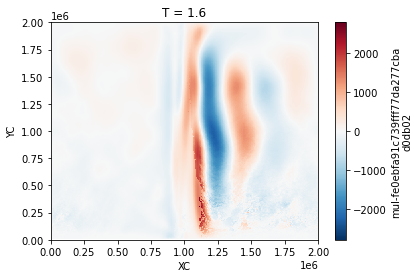

In [57]:
Vqs1.isel(T=10).plot()

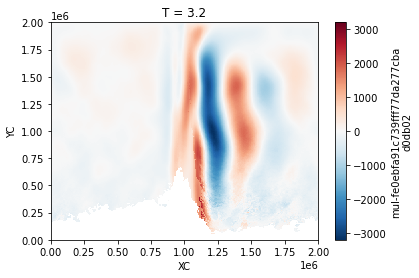

In [58]:
Vqs1.isel(T=20).plot()

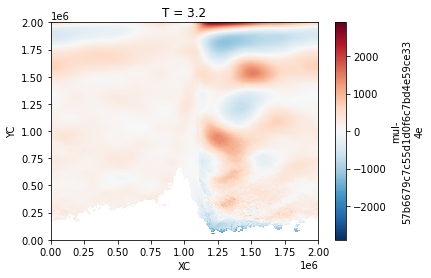

In [73]:
Uqs1.isel(T=20).plot()

In [9]:
ds_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored/'
ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')
# drop variables that have different axis, and not useful for TWA 
ds = ds.drop_vars(['Eta', 'PH', 'PHL','W']).chunk({'YC':100,'XC':100,'YG':100,'XG':100,
                                                   'Z':10,'Zl':10,'Zu':10,'Zp1':10})
ds

<xarray.Dataset>
Dimensions:              (YC: 400, XC: 400, Z: 40, Zp1: 41, time: 1980,
                          XG: 400, YG: 400, Zl: 40, Zu: 40,
                          layer_1TH_bounds: 43, layer_1TH_center: 42,
                          layer_1TH_interface: 41)
Coordinates: (12/32)
    Depth                (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    PHrefC               (Z) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    PHrefF               (Zp1) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * XC                   (XC) float32 2.5e+03 7.5e+03 ... 1.992e+06 1.998e+06
  * XG                   (XG) float32 0.0 5e+03 1e+04 ... 1.99e+06 1.995e+06
  * YC                   (YC) float32 2.5e+03 7.5e+03 ... 1.992e+06 1.998e+06
    ...                   ...
    maskW                (Z, YC, XG) bool dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
    rA                   (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAs                  (YG, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAw                  (YC, XG) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAz                  (YG, XG) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time                 (time) timedelta64[ns] 61023 days ... 66960 days
Data variables: (12/23)
    PTRACER01            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER02            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER03            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER04            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER05            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER06            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    ...                   ...
    PTRACER18            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER19            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    PTRACER20            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    T                    (time, Z, YC, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    U                    (time, Z, YC, XG) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>
    V                    (time, Z, YG, XC) float32 dask.array<chunksize=(35, 10, 100, 100), meta=np.ndarray>

In [10]:
grid = xgcm.Grid(ds, periodic='X')

In [19]:
# V at each time step interpolated onto `zeta_bar`
v = grid.interp(ds.V.reset_coords(drop=True),'Y',boundary='extend'
               ).interp(Z=zeta_bar).compute().chunk({'time':495,'YC':100,'XC':100,'T':10})
Z_grid = ds.Z * xr.ones_like(ds['T'].reset_coords(drop=True))
v

/home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/xarray/core/missing.py:640: PerformanceWarning: Increasing number of chunks by factor of 96
  interped = interp_func(
Task exception was never retrieved
future: <Task finished name='Task-7747' coro=<Client._gather.<locals>.wait() done, defined at /home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/distributed/client.py:1999> exception=AllExit()>


<xarray.DataArray 'mul-91ae9b3c299102db4dad1c9a2f69fa39' (time: 1980, YC: 400,
                                                          XC: 400, T: 51)>
dask.array<xarray-<this-array>, shape=(1980, 400, 400, 51), dtype=float32, chunksize=(495, 100, 100, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 61023 days 61026 days ... 66960 days
    Z        (YC, XC, T) float32 dask.array<chunksize=(100, 100, 17), meta=np.ndarray>
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * T        (T) float64 0.0 0.16 0.32 0.48 0.64 0.8 ... 7.36 7.52 7.68 7.84 8.0

In [74]:
u = grid.interp(ds.U.reset_coords(drop=True),'X',boundary='extend'
               ).interp(Z=zeta_bar).compute().chunk({'time':495,'YC':100,'XC':100,'T':10})

/home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/dbalwada/.conda/envs/GM-Redi-offline-env-labextension/lib/python3.10/site-packages/xarray/core/missing.py:640: PerformanceWarning: Increasing number of chunks by factor of 96
  interped = interp_func(


In [75]:
vdz = v * dzetab
udz = u * dzetab
vdz

<xarray.DataArray (time: 1980, YC: 400, XC: 400, T: 51)>
dask.array<mul, shape=(1980, 400, 400, 51), dtype=float32, chunksize=(495, 100, 100, 8), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 61023 days 61026 days ... 66960 days
    Z        (YC, XC, T) float32 dask.array<chunksize=(100, 100, 17), meta=np.ndarray>
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * T        (T) float64 0.0 0.16 0.32 0.48 0.64 0.8 ... 7.36 7.52 7.68 7.84 8.0

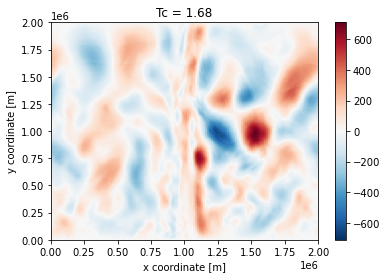

In [29]:
(grid.interp(ds.V.reset_coords(drop=True),'Y',boundary='extend'
            )*ds.drF
).where(Z_grid<grid_iso.interp(zeta_bar,'T',boundary='extend').isel(Tc=11)
       ).sum('Z',skipna=True
            ).isel(time=slice(None,10)).mean('time',skipna=True).plot()

In [55]:
# Vqs2 = xr.zeros_like(dzetab).load() * np.nan
# for i in range(len(dzetab['T'])):
    # Vqs2[...,i] = (v*ds.drF).where(Z_grid<grid_iso.interp(zeta_bar,'T',boundary='extend').isel(Tc=i+1), drop=True
    #                               ).sum('T',skipna=True
    #                                    ).mean('time',skipna=True).compute()
    # if i % 5 == 0:
    #     print(i)
Vqs2 = grid_iso.interp(grid_iso.cumsum(vdz,'T',boundary='extend'),
                       'T',boundary='extend'
                      ).where(zeta_bar<0.).mean('time',skipna=True).compute()
    
Vqs2

<xarray.DataArray 'mul-4935ceb5e8657e3ccbf1260da85d3b26' (YC: 400, XC: 400,
                                                          T: 51)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,  0.0000000e+00, -1.1655361e-01, ...,
                    nan,            nan,            nan],
        [           nan,  0.0000000e+00, -9.5937788e-02, ...,
                    nan,            nan,            nan],
        [           nan,  0.0000000e+00, -6.7284495e-02, ...,
                    nan,            nan,            nan],
...
        [-1.7216811e+00, -2.8750176e+00, -4.9101758e+00, ...,
         -2.5485329e+01, -2.5575781e+01,            nan],
        [-1.6541446e+00, -2.8169975e+00, -4.8411393e+00, ...,
         -2.4756643e+01, -2.4845053e+01,            nan],
        [-1.6524009e+00, -2.8796606e+00, -5.0044026e+00, ...,
         -2.4286327e+01, -2.4370546e+01,            nan]],

       [[-1.1035581e+00, -1.7799369e+00, -3.0873232e+00, ...,
         -1.5991872e+01, -1.6046686e+01,            nan],
        [-1.1428821e+00, -1.7939285e+00, -2.9965646e+00, ...,
         -1.5102286e+01, -1.5152823e+01,            nan],
        [-1.1094208e+00, -1.6612620e+00, -2.6610060e+00, ...,
         -1.3962734e+01, -1.4009424e+01,            nan],
        ...,
        [-1.0858041e+00, -1.6852626e+00, -2.8990929e+00, ...,
         -1.7354507e+01, -1.7417141e+01,            nan],
        [-1.0642636e+00, -1.6482701e+00, -2.8198361e+00, ...,
         -1.6749575e+01, -1.6811031e+01,            nan],
        [-1.0692263e+00, -1.6966864e+00, -2.9415157e+00, ...,
         -1.6447866e+01, -1.6506712e+01,            nan]]], dtype=float32)
Coordinates:
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * T        (T) float64 0.0 0.16 0.32 0.48 0.64 0.8 ... 7.36 7.52 7.68 7.84 8.0

In [76]:
Uqs2 = grid_iso.interp(grid_iso.cumsum(udz,'T',boundary='extend'),
                       'T',boundary='extend'
                      ).where(zeta_bar<0.).mean('time',skipna=True).compute()
    
Uqs2

<xarray.DataArray 'mul-94e2ee091a7fece57f1eec6c6159d529' (YC: 400, XC: 400,
                                                          T: 51)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,  0.00000000e+00, -1.23519928e+02, ...,
                     nan,             nan,             nan],
        [            nan,  0.00000000e+00, -1.23387863e+02, ...,
                     nan,             nan,             nan],
        [            nan,  0.00000000e+00, -1.23318375e+02, ...,
                     nan,             nan,             nan],
...
          1.03955969e+03,  1.04363220e+03,             nan],
        [-6.16363001e+00,  1.77283478e+00,  3.46981125e+01, ...,
          1.02324713e+03,  1.02725598e+03,             nan],
        [-6.75779247e+00,  3.86344880e-01,  3.18670654e+01, ...,
          1.00719116e+03,  1.01113660e+03,             nan]],

       [[-1.64867916e+01, -2.03979168e+01,  6.39014769e+00, ...,
          1.17577686e+03,  1.17991968e+03,             nan],
        [-1.70252190e+01, -2.16987228e+01,  3.46612024e+00, ...,
          1.15981921e+03,  1.16391211e+03,             nan],
        [-1.75992546e+01, -2.29676285e+01,  7.67589986e-01, ...,
          1.14488708e+03,  1.14893665e+03,             nan],
        ...,
        [-1.49121704e+01, -1.66880245e+01,  1.50680571e+01, ...,
          1.22689844e+03,  1.23122107e+03,             nan],
        [-1.54808369e+01, -1.79254093e+01,  1.22223997e+01, ...,
          1.20944653e+03,  1.21370898e+03,             nan],
        [-1.59489527e+01, -1.91175671e+01,  9.37115669e+00, ...,
          1.19247351e+03,  1.19667773e+03,             nan]]],
      dtype=float32)
Coordinates:
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * T        (T) float64 0.0 0.16 0.32 0.48 0.64 0.8 ... 7.36 7.52 7.68 7.84 8.0

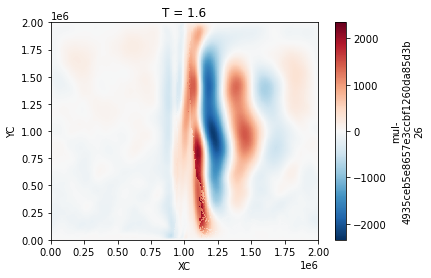

In [28]:
Vqs2.isel(T=10).plot()

In [77]:
Vqs = Vqs1 - Vqs2
Uqs = Uqs1 - Uqs2

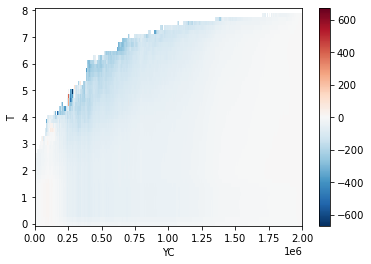

In [60]:
Vqs.mean('XC',skipna=True).plot(y='T')

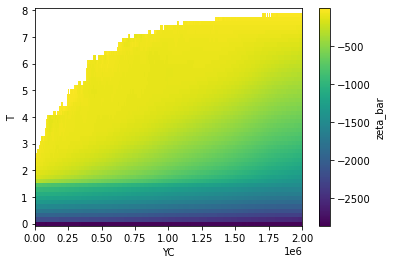

In [44]:
zeta_bar.mean('XC',skipna=True).plot(y='T')

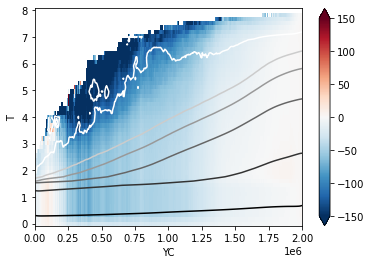

In [71]:
fig, ax = plt.subplots()
Vqs.mean('XC',skipna=True).plot(y='T', ax=ax, vmax=150, vmin=-150, cmap='RdBu_r')
zeta_bar.mean('XC',skipna=True).plot.contour(y='T', cmap='binary_r', 
                                             levels=[-2000,-1000,-500,-300,-200,-100])

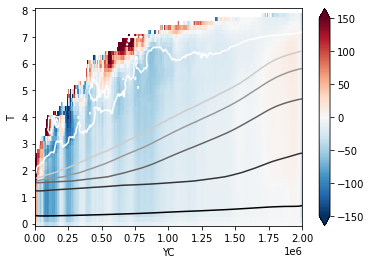

In [78]:
fig, ax = plt.subplots()
Uqs.mean('XC',skipna=True).plot(y='T', ax=ax, vmax=150, vmin=-150, cmap='RdBu_r')
zeta_bar.mean('XC',skipna=True).plot.contour(y='T', cmap='binary_r', 
                                             levels=[-2000,-1000,-500,-300,-200,-100])

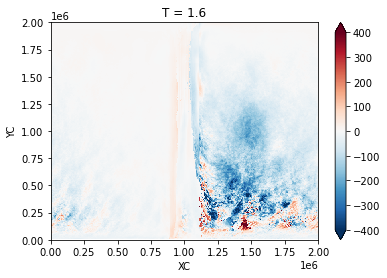

In [84]:
Vqs.isel(T=10).plot(vmax=400)

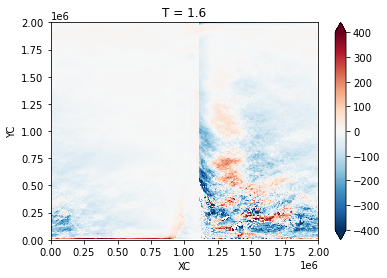

In [85]:
Uqs.isel(T=10).plot(vmax=400)

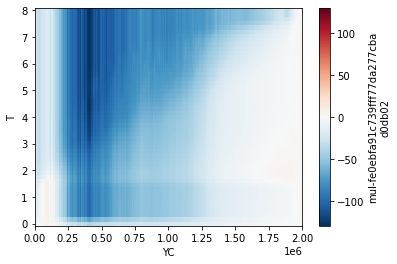

In [41]:
Vqs1.mean('XC').plot(y='T')

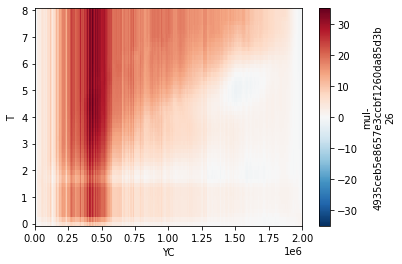

In [42]:
(-Vqs2).mean('XC').plot(y='T')